In [1]:
"""
Little helper function to load data from a .trc binary file.
This is the file format used by LeCroy oscilloscopes.
M. Betz 09/2015
"""
import datetime
import numpy as np
import struct

def readTrc( fName ):
    """
        Reads .trc binary files from LeCroy Oscilloscopes.
        Decoding is based on LECROY_2_3 template.
        [More info](http://forums.ni.com/attachments/ni/60/4652/2/LeCroyWaveformTemplate_2_3.pdf)
        
        Parameters
        -----------       
        fName = filename of the .trc file
        
        Returns
        -----------       
        x: array with sample times [s],
        
        y: array with sample  values [V],
        
        d: dictionary with metadata
        
        
        M. Betz 09/2015
    """
    with open(fName, "rb") as fid:
        data = fid.read(50).decode()
        wdOffset = data.find('WAVEDESC')
        
        #------------------------
        # Get binary format / endianess
        #------------------------
        if readX( fid, 'H', wdOffset + 32 ):  #16 or 8 bit sample format?
            smplFmt = "int16"
        else:
            smplFmt = "int8"
        if readX( fid, 'H', wdOffset + 34 ):  #Big or little endian?
            endi = "<"
        else:
            endi = ">"
            
        #------------------------
        # Get length of blocks and arrays:
        #------------------------
        lWAVE_DESCRIPTOR = readX( fid, endi+"l", wdOffset + 36 )
        lUSER_TEXT       = readX( fid, endi+"l", wdOffset + 40 )
        lTRIGTIME_ARRAY  = readX( fid, endi+"l", wdOffset + 48 )
        lRIS_TIME_ARRAY  = readX( fid, endi+"l", wdOffset + 52 )
        lWAVE_ARRAY_1    = readX( fid, endi+"l", wdOffset + 60 )
        lWAVE_ARRAY_2    = readX( fid, endi+"l", wdOffset + 64 )

        d = dict()  #Will store all the extracted Metadata
        
        #------------------------
        # Get Instrument info
        #------------------------
        d["INSTRUMENT_NAME"]  = readX( fid, "16s",    wdOffset + 76 ).decode().split('\x00')[0]
        d["INSTRUMENT_NUMBER"]= readX( fid, endi+"l", wdOffset + 92 )
        d["TRACE_LABEL"]      = readX( fid, "16s",    wdOffset + 96 ).decode().split('\x00')[0]
        
        #------------------------
        # Get Waveform info      
        #------------------------
        d["WAVE_ARRAY_COUNT"] = readX( fid, endi+"l", wdOffset +116 )
        d["PNTS_PER_SCREEN"]  = readX( fid, endi+"l", wdOffset +120 )
        d["FIRST_VALID_PNT"]  = readX( fid, endi+"l", wdOffset +124 )
        d["LAST_VALID_PNT"]   = readX( fid, endi+"l", wdOffset +128 )
        d["FIRST_POINT"]      = readX( fid, endi+"l", wdOffset +132 )
        d["SPARSING_FACTOR"]  = readX( fid, endi+"l", wdOffset +136 )
        d["SEGMENT_INDEX"]    = readX( fid, endi+"l", wdOffset +140 )
        d["SUBARRAY_COUNT"]   = readX( fid, endi+"l", wdOffset +144 )
        d["SWEEPS_PER_ACQ"]   = readX( fid, endi+"l", wdOffset +148 )
        d["POINTS_PER_PAIR"]  = readX( fid, endi+"h", wdOffset +152 )
        d["PAIR_OFFSET"]      = readX( fid, endi+"h", wdOffset +154 )
        d["VERTICAL_GAIN"]    = readX( fid, endi+"f", wdOffset +156 ) #to get floating values from raw data :
        d["VERTICAL_OFFSET"]  = readX( fid, endi+"f", wdOffset +160 ) #VERTICAL_GAIN * data - VERTICAL_OFFSET 
        d["MAX_VALUE"]        = readX( fid, endi+"f", wdOffset +164 )
        d["MIN_VALUE"]        = readX( fid, endi+"f", wdOffset +168 )
        d["NOMINAL_BITS"]     = readX( fid, endi+"h", wdOffset +172 )
        d["NOM_SUBARRAY_COUNT"]= readX( fid, endi+"h",wdOffset +174 )
        d["HORIZ_INTERVAL"]   = readX( fid, endi+"f", wdOffset +176 ) #sampling interval for time domain waveforms 
        d["HORIZ_OFFSET"]     = readX( fid, endi+"d", wdOffset +180 ) #trigger offset for the first sweep of the trigger, seconds between the trigger and the first data point 
        d["PIXEL_OFFSET"]     = readX( fid, endi+"d", wdOffset +188 )
        d["VERTUNIT"]         = readX( fid, "48s", wdOffset +196 ).decode().split('\x00')[0]
        d["HORUNIT"]          = readX( fid, "48s", wdOffset +244 ).decode().split('\x00')[0]
        d["HORIZ_UNCERTAINTY"]= readX( fid, endi+"f", wdOffset +292 )
        d["TRIGGER_TIME"]     = getTimeStamp( fid, endi, wdOffset +296 )
        d["ACQ_DURATION"]     = readX( fid, endi+"f", wdOffset +312 )
        d["RECORD_TYPE"]      = ["single_sweep","interleaved","histogram","graph","filter_coefficient","complex","extrema","sequence_obsolete","centered_RIS","peak_detect"][ readX( fid, endi+"H", wdOffset +316 ) ]
        d["PROCESSING_DONE"]  = ["no_processing","fir_filter","interpolated","sparsed","autoscaled","no_result","rolling","cumulative"][ readX( fid, endi+"H", wdOffset +318 ) ]
        d["RIS_SWEEPS"]       = readX( fid, endi+"h", wdOffset +322 )
        d["TIMEBASE"]         = ['1_ps/div', '2_ps/div', '5_ps/div', '10_ps/div', '20_ps/div', '50_ps/div', '100_ps/div', '200_ps/div', '500_ps/div', '1_ns/div', '2_ns/div', '5_ns/div', '10_ns/div', '20_ns/div', '50_ns/div', '100_ns/div', '200_ns/div', '500_ns/div', '1_us/div', '2_us/div', '5_us/div', '10_us/div', '20_us/div', '50_us/div', '100_us/div', '200_us/div', '500_us/div', '1_ms/div', '2_ms/div', '5_ms/div', '10_ms/div', '20_ms/div', '50_ms/div', '100_ms/div', '200_ms/div', '500_ms/div', '1_s/div', '2_s/div', '5_s/div', '10_s/div', '20_s/div', '50_s/div', '100_s/div', '200_s/div', '500_s/div', '1_ks/div', '2_ks/div', '5_ks/div', 'EXTERNAL'][ readX( fid, endi+"H", wdOffset +324 ) ]
        d["VERT_COUPLING"]    = ['DC_50_Ohms', 'ground', 'DC_1MOhm', 'ground', 'AC,_1MOhm'][ readX( fid, endi+"H", wdOffset +326 ) ]
        d["PROBE_ATT"]        = readX( fid, endi+"f", wdOffset +328 )
        d["FIXED_VERT_GAIN"]  = ['1_uV/div','2_uV/div','5_uV/div','10_uV/div','20_uV/div','50_uV/div','100_uV/div','200_uV/div','500_uV/div','1_mV/div','2_mV/div','5_mV/div','10_mV/div','20_mV/div','50_mV/div','100_mV/div','200_mV/div','500_mV/div','1_V/div','2_V/div','5_V/div','10_V/div','20_V/div','50_V/div','100_V/div','200_V/div','500_V/div','1_kV/div'][ readX( fid, endi+"H", wdOffset +332 ) ]
        d["BANDWIDTH_LIMIT"]  = ['off', 'on'][ readX( fid, endi+"H", wdOffset +334 ) ]
        d["VERTICAL_VERNIER"] = readX( fid, endi+"f", wdOffset +336 )
        d["ACQ_VERT_OFFSET"]  = readX( fid, endi+"f", wdOffset +340 )
        d["WAVE_SOURCE"]      = readX( fid, endi+"H", wdOffset +344 )
        d["USER_TEXT"]        = readX( fid, "{0}s".format(lUSER_TEXT), wdOffset + lWAVE_DESCRIPTOR ).decode().split('\x00')[0]

        #------------------------
        # Get main sample data with the help of numpys .fromfile(
        #------------------------
        fid.seek( wdOffset + lWAVE_DESCRIPTOR + lUSER_TEXT + lTRIGTIME_ARRAY + lRIS_TIME_ARRAY ) #Seek to WAVE_ARRAY_1
        y = np.fromfile( fid, smplFmt, lWAVE_ARRAY_1 )
        if endi == ">":
            y.byteswap( True )
        y = d["VERTICAL_GAIN"] * y - d["VERTICAL_OFFSET"]
        x = np.arange(1,len(y)+1)*d["HORIZ_INTERVAL"] + d["HORIZ_OFFSET"]
    return x, y, d

def readX( fid, fmt, adr=None ):
    """ extract a byte / word / float / double from the binary file """
    nBytes = struct.calcsize( fmt )
    if adr is not None:
        fid.seek( adr )
    s = struct.unpack( fmt, fid.read( nBytes ) )
    if(type(s) == tuple):
        return s[0]
    else:
        return s

def getTimeStamp( fid, endi, adr ):
    """ extract a timestamp from the binary file """
    s = readX( fid, endi+"d", adr )
    m = readX( fid, endi+"b" )
    h = readX( fid, endi+"b" )
    D = readX( fid, endi+"b" )
    M = readX( fid, endi+"b" )
    Y = readX( fid, endi+"h" )
    trigTs = datetime.datetime(Y, M, D, h, m, int(s), int((s-int(s))*1e6) )
return trigTs

SyntaxError: 'return' outside function (<ipython-input-1-7e2099bbb137>, line 138)

average_full: -0.0004585669439721903
std_full: 0.004966986344796797
average: -0.00043992288932859084
std: 0.004847069849662049
how many peaks: 192


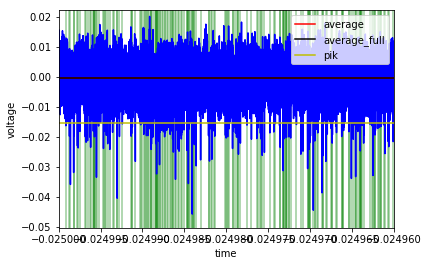

In [16]:
import matplotlib.pyplot as plt
import numpy as np
#from matplotlib.ticker import PercentFormatter
import scipy

plt.subplots_adjust(hspace=0.8,wspace=0.8)
start=0
finish=100000

x0=readTrc("C1diamond10000000-Copy1.trc")
x0noise=readTrc("C1diamond10000000noise-Copy1.trc")
average_full=np.mean(x0[1])
std_full=np.std(x0[1])
print("average_full: "+str(average_full))
print("std_full: "+str(std_full))

x=x0[0][start:finish]
y=x0[1][start:finish]
xnoise=x0noise[0][start:finish]
ynoise=x0noise[1][start:finish]

average=np.mean(y)
std=np.std(y)
print ("average: " +str(average))
print("std: "+str(std))

######szukanie pikow#####
pikx=[]
pik=average_full-3*std_full
for i in range(0,finish-start-10):
    if ( y[i] <= y[i-1] and y[i] <= y[i+1] and y[i]<y[i+10] and y[i]<pik):
        if(len(pikx)==0):
            pikx.append(x[i])
        if(x[i]-pikx[-1]>50*np.abs(x[1]-x[0])):
            pikx.append(x[i])
print("how many peaks: "+str(len(pikx)))
##########################


for i in pikx:
    plt.axvline(x=i,color='g',alpha=0.4)
plt.plot(x,y,'b')
plt.plot([x[0],x[-1]],[average,average],'r',label='average')
plt.plot([x[0],x[-1]],[average_full,average_full],'k',label='average_full')
plt.plot([x[0],x[-1]],[pik,pik],'y',label='pik')
#plt.plot([x[0],x[-1]],[average+std,average+std],'r')
plt.axis([x[0],x[-1],np.min(y)+0.1*np.min(y),np.max(y)+0.1*np.max(y)])
plt.xlabel('time')
plt.ylabel('voltage')
plt.legend(loc='upper right')
plt.show()

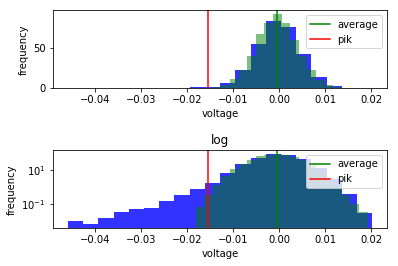

In [17]:
###############HISTO##############
plt.subplots_adjust(hspace=0.8,wspace=0.8)
plt.subplot(2,1,1)
plt.hist(y,bins=20,normed=1,alpha=0.8,color='b')
plt.hist(ynoise,bins=20,normed=1,alpha=0.5,color='g')
plt.ylabel('frequency')
plt.xlabel('voltage')
plt.axvline(x=average_full,color='g',label='average')
plt.axvline(x=pik,color='r',label='pik')
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.ylabel('frequency')
plt.xlabel('voltage')
plt.title('log')
plt.hist(y,bins=20,normed=1,log=True,alpha=0.8,color='b')
plt.hist(ynoise,bins=20,normed=1,log=True,alpha=0.5,color='g')
plt.axvline(x=average_full,color='g',label='average')
plt.axvline(x=pik,color='r',label='pik')
plt.legend(loc='upper right')
plt.show()


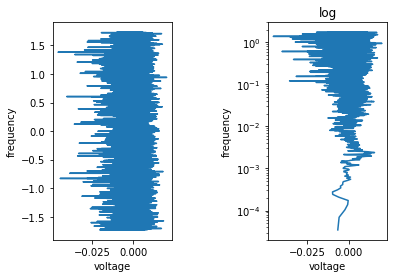

In [18]:
############FREQUENCY################
plt.subplots_adjust(hspace=0.8,wspace=0.8)
frequency=np.fft.fftfreq(y.size)
plt.subplot(1,2,1)
plt.xlabel('voltage')
plt.ylabel('frequency')
frequency_norm=[num/scipy.std(frequency) for num in frequency]
plt.plot(y,frequency_norm)


plt.subplot(1,2,2)
plt.plot(y,frequency_norm)
plt.yscale('log')
plt.title('log')
plt.xlabel('voltage')
plt.ylabel('frequency')
plt.show()